In [1]:
cd /content/drive/My Drive/DL/CS 189/hw3

/content/drive/My Drive/DL/CS 189/hw3


**1.Isocontours of Normal Distributions**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [0]:
def get_pdf_1(mean, cov, title, num):
  x, y = np.mgrid[-6:6:.01, -6:6:.01]
  comb = np.dstack((x,y))
  fun = multivariate_normal(mean,cov)
  plt.figure(num)
  plt.title(title)
  plt.contourf(x, y, fun.pdf(comb))
  plt.colorbar()

def get_pdf_2(mean1, mean2, cov1, cov2, title, num):
  x, y = np.mgrid[-6:6:.01, -6:6:.01]
  comb = np.dstack((x,y))
  fun1 = multivariate_normal(mean1,cov1)
  fun2 = multivariate_normal(mean2,cov2)
  plt.figure(num)
  plt.title(title)
  plt.contourf(x, y, fun1.pdf(comb)-fun2.pdf(comb))
  plt.colorbar()

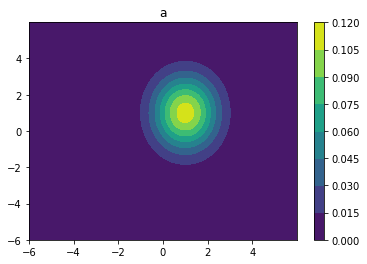

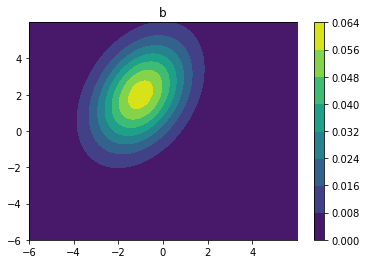

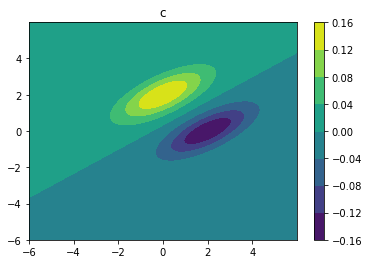

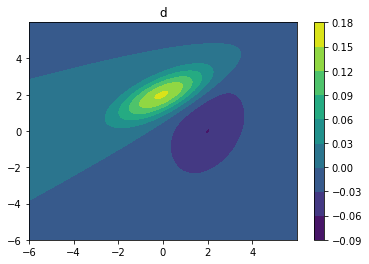

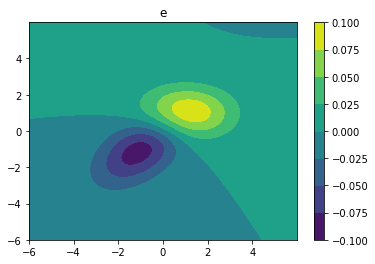

In [4]:
get_pdf_1([1,1],[[1,0],[0,2]],"a",1)
get_pdf_1([-1,2],[[2,1],[1,4]],"b",2)
get_pdf_2([0,2], [2,0], [[2,1],[1,1]], [[2,1],[1,1]], "c",3)
get_pdf_2([0,2], [2,0], [[2,1],[1,1]], [[2,1],[1,4]], "d",4)
get_pdf_2([1,1], [-1,-1], [[2,0],[0,1]], [[2,1],[1,2]], "e",5)

**2.Eigenvectors of the Gaussian Covariance Matrix**

In [0]:
X1 = np.random.normal(3.0, 3.0, 100)
X2 = np.random.normal(4.0, 2.0, 100)
sample = np.array([[x1,x1*0.5+x2] for x1, x2 in zip(X1,X2)])

In [6]:
sample_mean = np.mean(sample, axis=0)
print(sample_mean)

[2.74696915 5.24987198]


In [7]:
sample_cov = np.cov(sample, rowvar=False)
print(sample_cov)

[[10.32326851  5.18335847]
 [ 5.18335847  6.19545684]]


In [8]:
eigen_vals, eigen_vecs = np.linalg.eig(sample_cov)
print("eigrn_vals: {}\n eigen_vecs: {}".format(eigen_vals, eigen_vecs))

eigrn_vals: [13.83851247  2.68021289]
 eigen_vecs: [[ 0.82762672 -0.56127891]
 [ 0.56127891  0.82762672]]


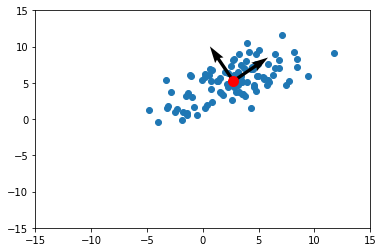

In [9]:
plt.axis((-15,15,-15,15))
plt.scatter(sample[:,0],sample[:,1])

plt.xlim(left = -15, right = 15)
plt.ylim(bottom = -15, top = 15)
plt.plot(sample_mean[0],sample_mean[1],marker="o", color="red", markersize=10)
plt.quiver([sample_mean[0]]*2, [sample_mean[1]]*2, eigen_vecs[:,1], eigen_vecs[:,0], width=0.01, scale=8)

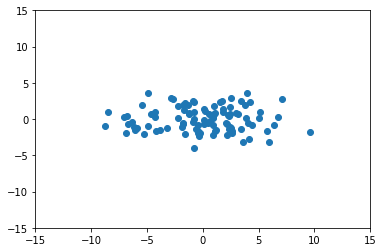

In [10]:
points = (np.dot(eigen_vecs.T, (sample-sample_mean).T)).T
plt.axis((-15,15,-15,15))
plt.scatter(points[:,0],points[:,1])

**3.Gaussian Classifiers for Digits and Spam**

In [0]:
from scipy.io import loadmat
mnist = loadmat("./data/mnist_data.mat")
mnist_trainx = mnist["training_data"].astype(np.float32)
mnist_trainy = mnist["training_labels"]
mnist_trainx = (mnist_trainx-np.mean(mnist_trainx))/np.std(mnist_trainx) # normalize

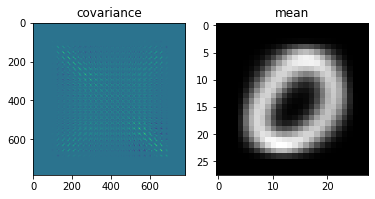

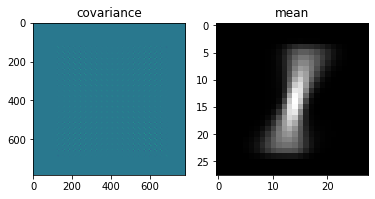

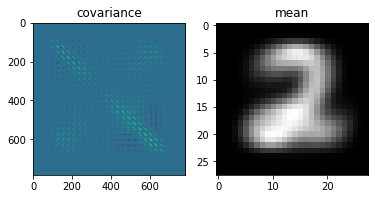

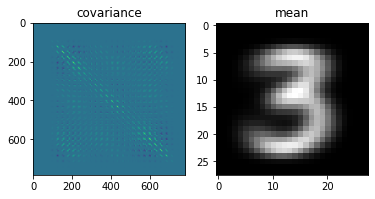

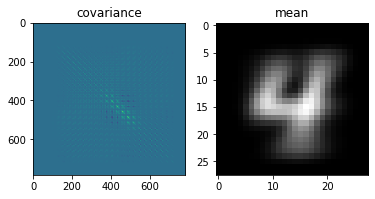

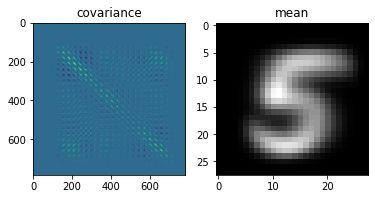

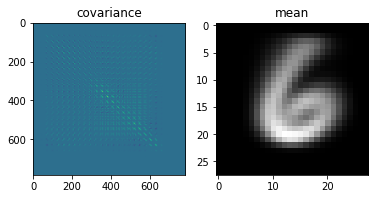

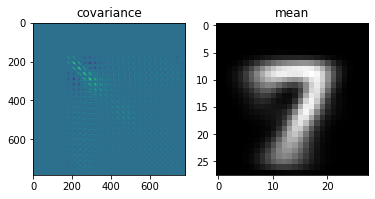

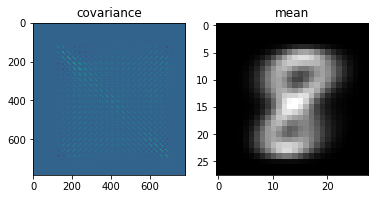

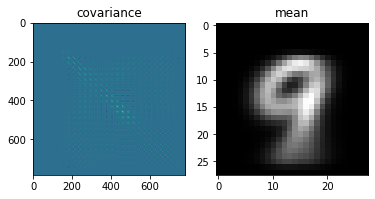

In [12]:
for i in range(10):
  index = np.where(mnist_trainy == i)[0]
  tmp_mean = np.mean(mnist_trainx[index],axis=0)
  tmp_cov = np.cov(mnist_trainx[index], rowvar=False, bias=True)
  fig, (a1,a2) = plt.subplots(1, 2)
  a1.imshow(tmp_cov)
  a1.set_title("covariance")
  a2.imshow(tmp_mean.reshape(28,28),cmap="gray")
  a2.set_title("mean")

**3.(a)**

In [0]:
mnist = loadmat("./data/mnist_data.mat")
state = np.random.get_state()
mnist_train = mnist["training_data"]
mnist_train_label = mnist["training_labels"]
np.random.shuffle(mnist_train)
np.random.set_state(state)
np.random.shuffle(mnist_train_label)

val_x = mnist_train[-10000:]
val_y = mnist_train_label[-10000:]
train_x = mnist_train[:-10000]
train_y = mnist_train_label[:-10000]
train_x = (train_x - np.mean(train_x)) / np.std(train_x)
val_x = (val_x - np.mean(val_x)) / np.std(val_x)

In [0]:
def cal_LDA(num, train_x, train_y):
  means = []
  covs = []
  prior = []
  for i in range(10):
    index = np.where(train_y[:num] == i)[0]
    tmp_mean = np.mean(train_x[index],axis=0)
    tmp_cov = np.cov(train_x[index], rowvar=False, bias=True)
    means.append(tmp_mean)
    covs.append(tmp_cov)
    prior.append(len(index)/num)
  cov_LDA = np.mean(covs)
  prior_LDA = np.array(prior)
  return means, covs, prior_LDA, cov_LDA

def gaussian_LDA(means, cov):
  L=[]
  for mean in means:
    L.append(multivariate_normal(mean, cov, allow_singular=True))
  return L

def prediction_LDA(datas, gaussians, priors):
  pdfs = np.array([gauss.logpdf(datas) for gauss in gaussians]).T
  post = pdfs+np.log(priors)
  prediction = post.argmax(axis=1)
  return prediction

In [0]:
def train_LDA(nums, train_x, train_y, val_x, val_y):
  train_errs, val_errs = [], []
  for num in nums:
    means, covs, prior_LDA, cov_LDA = cal_LDA(num, train_x, train_y)
    gaussians = gaussian_LDA(means, cov_LDA)
    train_predictions = prediction_LDA(train_x, gaussians, prior_LDA).reshape(*train_y.shape)
    val_predictions = prediction_LDA(val_x, gaussians, prior_LDA).reshape(*val_y.shape)
    train_errs.append(np.sum(train_predictions != train_y)/train_y.shape[0])
    val_errs.append(np.sum(val_predictions != val_y)/val_y.shape[0])
  plt.plot(nums, train_errs)
  plt.plot(nums, val_errs)
  plt.legend(["train_error", "val_error"])
  plt.xlabel("train size")
  plt.ylabel("errors")

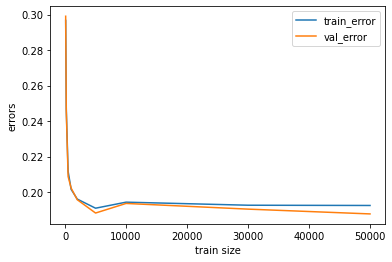

In [53]:
nums=[100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
train_LDA(nums, train_x, train_y, val_x, val_y)

In [0]:
def gaussian_QDA(means, covs):
  L=[]
  for i in range(len(means)):
    L.append(multivariate_normal(means[i], covs[i], allow_singular=True))
  return L

In [0]:
def train_QDA(nums, train_x, train_y, val_x, val_y):
  train_errs, val_errs = [], []
  for num in nums:
    means, covs, prior, cov_QDA = cal_LDA(num, train_x, train_y)
    gaussians = gaussian_QDA(means, covs)
    train_predictions = prediction_LDA(train_x, gaussians, prior).reshape(*train_y.shape)
    val_predictions = prediction_LDA(val_x, gaussians, prior).reshape(*val_y.shape)
    train_errs.append(np.sum(train_predictions != train_y)/train_y.shape[0])
    val_errs.append(np.sum(val_predictions != val_y)/val_y.shape[0])
  plt.plot(nums, train_errs)
  plt.plot(nums, val_errs)
  plt.legend(["train_error", "val_error"])
  plt.xlabel("train size")
  plt.ylabel("errors")

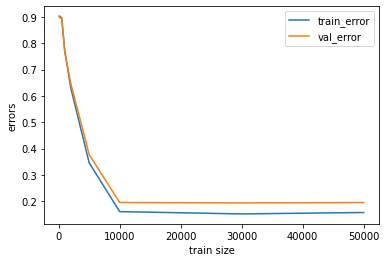

In [58]:
nums=[100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
train_QDA(nums, train_x, train_y, val_x, val_y)